## setting up

### regex

In [ ]:
# test = '( skeptical :domain ( I ) :mod ( little ) :ARG1-of ( cause :ARG0 ( cheap :ARG1 ( it ) :degree ( so ) ) ) )'

In [ ]:
# import random

# ### random deletion (leaves)
# def _random_delete_leave(line):  # if graph has only one node, this function will do nothing
#     is_leaf = False
#     stack = []
#     candidate = []
#     leaves = []
#     for item in line.split():
#         if item.startswith(':polarity'):
#             continue
#         elif item.startswith(':') and not is_leaf:
#             is_leaf = True
#             candidate = [item]
#         elif item.startswith(':') and len(stack) > 0:
#             candidate = [item]
#             stack = []
#         elif item == '(' and is_leaf:
#             candidate.append(item)
#             stack.append(item)
#         elif item == ')':
#             if len(stack) == 1:
#                 stack = []
#                 candidate.append(')')
#                 leaves.append(' '.join(candidate))
#                 candidate = []
#             elif len(stack) == 0 and len(candidate) > 0:
#                 leaves.append(' '.join(candidate))
#                 candidate = []
#         elif is_leaf:
#             candidate.append(item)
#         else:
#             continue
#     print(leaves)
#     print(candidate)
#     print(stack)
#     if len(leaves) > 0:
#         cand = random.choice(leaves)
#         new_line = line.replace(cand, '').replace('\s+', ' ')
#         # print(cand,new_line)
#         return new_line
#     else:
#         return line

# def random_delete_leaf(line, n=1, alpha=0.1):
#     augs = []
#     num_leaf = len([i for i in line if i.startswith(':')])
#     while n > 0:
#         new_line = line
#         n_rd = max(1, int(alpha * num_leaf))
#         while n_rd > 0:
#             new_line = _random_delete_leave(new_line)
#             n_rd -= 1
#         augs.append(new_line)
#         n -= 1
#     return augs


# def write_delete_leaf(input, output, alpha=0.1, n=1):
#     # new_file = file.replace('.source', '_del_leafaug_n%d.source' % n)
#     new_lines = []
#     with open(input, 'r') as f:
#         lines = f.readlines()

#     for line in lines:
#         try:
#             label, sentence = line.strip().split('\t')
#             new_line = random_delete_leaf(sentence, n, alpha)
#             new_line = [label + '\t' + line for line in new_line]
#         except:
#             new_line = random_delete_leaf(line.strip(), n, alpha)
#         new_lines.append('\n'.join(new_line) + '\n')
#     with open(output, 'w') as wf:
#         wf.writelines(new_lines)

#     print('delete finish')

### read data

In [2]:
# %pip install penman
# %pip install mip==1.13.0
# %pip install smatchpp

In [1]:
import os
import penman
import smatch
import re
import random
import copy
from tqdm import tqdm
import time
from pyvi import ViTokenizer, ViPosTagger
from gensim.models import KeyedVectors # type: ignore
import json
import matplotlib.pyplot as plt
import numpy as np
from string import punctuation

In [3]:
base_dir = '../data/viamr/reformat'
paths = [base_dir + '/' + fn for fn in os.listdir(base_dir)]
paths

['../data/viamr/reformat/reformat_user10_v3__user8_v2.txt',
 '../data/viamr/reformat/reformat_user10_v3__user9_v2.txt',
 '../data/viamr/reformat/reformat_user11_v3.txt',
 '../data/viamr/reformat/reformat_user8_v3.txt',
 '../data/viamr/reformat/reformat_user9_v3_1.txt']

In [4]:
# read all text and graphs
texts = []
graphs = []
for path in paths:
    with open(path, encoding='utf8') as f:
        data = f.read().split('\n\n')
        for sample in data[:]:
            idx = sample.find('\n')
            texts.append(sample[:idx].lower())
            graphs.append(sample[idx:].strip())

In [5]:
len(graphs)
len(texts)

1516

In [6]:
i = random.randint(0, len(texts))
print(texts[i])
print(graphs[i])

#::snt và họ sẽ tưởng ông điên .
(a / and
    :op2(t / tưởng
        :agent(h / họ)
        :tense(s / sẽ)
        :topic(đ / điên
            :domain(ô / ông))))


In [7]:
# prepare insertion nodes list
insert_dir = '../data/viamr/augmented/node-level/candidates/insert'
insert_files = [f'{insert_dir}/{file}' for file in os.listdir(insert_dir)]
insert_nodes = []
n_nodes = []
for file in insert_files:
    with open(file, encoding='utf-8') as f:
        content = [line.strip() for line in f.readlines()]
        insert_nodes += content
        n_nodes.append(len(content))
random.shuffle(insert_nodes)
len(insert_nodes)

1169

In [9]:
# set up tools (corpus)
file = '../data/viwordnet-dash-by-type.json'
with open(file, encoding='utf-8') as f:
    wordnet = json.load(f)

w2v_path = '../data/corpus/word2vec_vi_words_100dims.txt'
w2v = KeyedVectors.load_word2vec_format(w2v_path, binary=False)

model_w2v = {'type': 'w2v', 'model': w2v}
model_wordnet = {'type': 'wordnet', 'model': wordnet}

In [10]:
def get_sent_type(graph):
    type = []
    if 'amr-unknown' in graph:
        type.append('wh-question')
    elif ':mode interrogative' in graph: 
        type.append('yes-no-question')
    elif ':mode imperative' in graph:
        type.append('imperative')
    elif ':mode expressive' in graph:
        type.append('exclamative')

    if 'multi-sentence' in graph:
        type.append('multi-sentence')
    if 'polarity -' in graph:
        type.append('negative')
    return type

def get_info():
    data = {}
    for i in range(len(graphs)):
        text = texts[i][7:].strip()
        translator = str.maketrans('', '', punctuation)
        tokens = text.translate(translator)
        data[i] = {'ori_text': text, 'ori_graph': graphs[i], 
                'text_len': len(tokens.split()), 'n_edges': graphs[i].count(':'),
                'sent_type': get_sent_type(graphs[i])}
    return data

In [11]:
data = get_info()

### statistics

(array([102., 208., 257., 224., 184., 138.,  85., 109.,  60.,  46.,  27.,
         11.,  16.,   8.,   4.,  11.,   2.,   4.,   3.,   2.,   2.,   5.,
          1.,   2.,   2.,   1.,   1.,   0.,   0.,   1.]),
 array([ 1.        ,  3.13333333,  5.26666667,  7.4       ,  9.53333333,
        11.66666667, 13.8       , 15.93333333, 18.06666667, 20.2       ,
        22.33333333, 24.46666667, 26.6       , 28.73333333, 30.86666667,
        33.        , 35.13333333, 37.26666667, 39.4       , 41.53333333,
        43.66666667, 45.8       , 47.93333333, 50.06666667, 52.2       ,
        54.33333333, 56.46666667, 58.6       , 60.73333333, 62.86666667,
        65.        ]),
 <BarContainer object of 30 artists>)

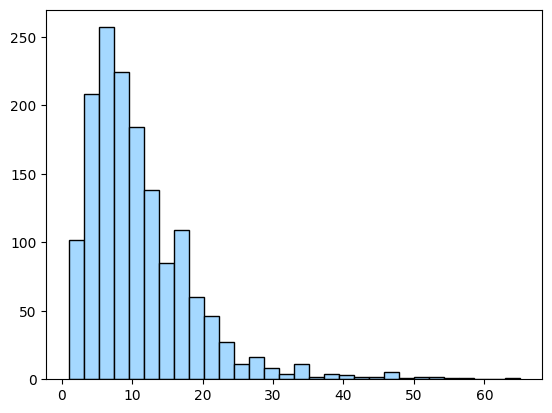

In [ ]:
# plot text length distribution
plt.hist([data[i]['text_len'] for i in data], bins=30, edgecolor='black', color='#a5d8ff')
plt.xlabel('Số từ trong câu')
plt.ylabel('Số câu')

(array([518., 513., 297., 103.,  42.,  14.,  14.,   8.,   4.,   3.]),
 array([ 0. ,  4.5,  9. , 13.5, 18. , 22.5, 27. , 31.5, 36. , 40.5, 45. ]),
 <BarContainer object of 10 artists>)

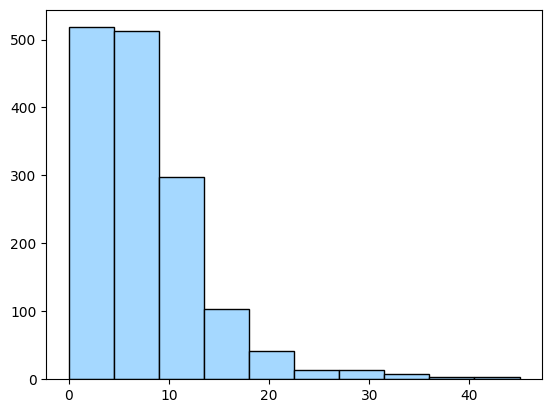

In [ ]:
# plot amr length distribution
plt.hist([data[i]['n_edges'] for i in data], edgecolor='black', color='#a5d8ff')
plt.xlabel('Số cạnh trong AMR')
plt.ylabel('Số lượng AMR')

In [ ]:
# length distribution by groups
def count_len(data):
    groups = ['1-10', '11-20', '21-30', '31-40', '41-50', '>50']
    count = [0, 0, 0, 0, 0, 0]
    indexs = [[], [], [], [], [], []]
    for i in range(len(data)):
        length = data[i][1]
        if length < 7:
            count[0] += 1
            indexs[0].append(i)
        elif length < 15:
            count[1] += 1
            indexs[1].append(i)
        elif length < 20:
            count[2] += 1
            indexs[2].append(i)
        elif length < 30:
            count[3] += 1
            indexs[3].append(i)
        elif length < 40:
            count[4] += 1
            indexs[4].append(i)
        else:
            count[5] += 1
            indexs[5].append(i)
    return count, indexs

In [ ]:
# number of sentences by types (eng version)
types = ['wh-question', 'yes-no-question', 'imperative', 'exclamative', 'negative', 'multi-sentence']
tcount = [0, 0, 0, 0, 0, 0]
for i in data:
    sent_type = data[i]['sent_type']
    if len(sent_type) > 0:
        for t in sent_type:
            tcount[types.index(t)] += 1

In [ ]:
# number of sentences by types (vie version)
vtypes = ['câu phủ định', 'câu hỏi', 'câu cảm thán', 'câu mệnh lệnh', 'câu ghép chuỗi']
vtcount = [156] + tcount[2:]

Text(0.5, 0, 'Số câu')

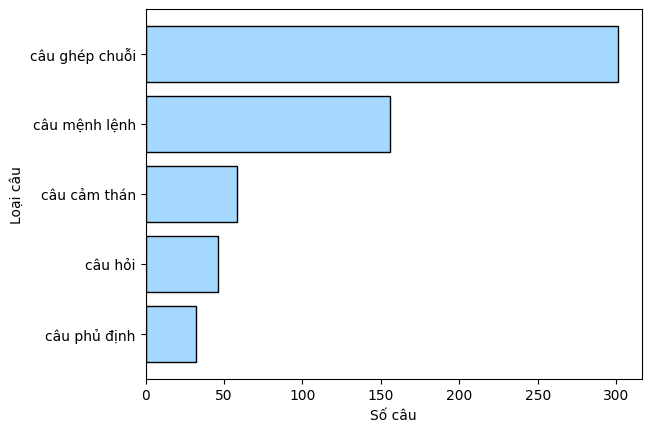

In [ ]:
# plot number of sentences by types
plt.barh(vtypes, sorted(vtcount), edgecolor='black', color='#a5d8ff')
plt.ylabel('Loại câu')
plt.xlabel('Số câu')

In [ ]:
# get subset (evaluation set) according to length distribution
def get_subset(n_sample, count, indexs, data):
    n_sampling = [int(np.ceil(c / len(data) * n_sample)) for c in count]
    print(sum(n_sampling))

    id_set = []
    for i in range(len(n_sampling)):
        id_set += random.sample(indexs[i], k=n_sampling[i]) 
    random.shuffle(id_set)
    id_set = id_set[:n_sample]
    id_set_len = [data[i][1] for i in id_set]
    print(id_set_len)
    plt.hist(id_set_len, bins=30)
    return id_set

In [ ]:
# idset = [(id, augs_method[id]['text_len'], augs_method[id]['n_edges']) for id in augs_method]
# len_counts, len_indexs = count_len(idset)

# text_lens = [i[1] for i in idset]
# n_edges = [i[2] for i in idset]

# id_set_100 = get_subset(100, len_counts, len_indexs, idset)

# id_set_100_i = [idset[i][0] for i in id_set_100]

# subset = {i:augs_method[i] for i in id_set_100_i}

# with open('data/viamr/augmented/id_set_100.txt', 'w') as f:
#     for id in range(len(id_set_100_i)):
#         f.write(str(id_set_100_i))
#         f.write('\n')

102
[15, 19, 8, 9, 7, 39, 7, 15, 9, 9, 32, 6, 9, 6, 8, 9, 9, 14, 23, 22, 5, 19, 6, 20, 5, 7, 8, 3, 6, 14, 6, 3, 11, 11, 8, 18, 8, 24, 4, 4, 3, 3, 11, 22, 4, 8, 43, 15, 12, 10, 4, 4, 11, 7, 9, 26, 18, 6, 13, 11, 18, 16, 16, 4, 22, 12, 6, 2, 10, 11, 12, 4, 6, 5, 15, 3, 9, 11, 2, 16, 8, 52, 6, 10, 8, 10, 11, 13, 10, 13, 7, 24, 6, 27, 6, 21, 11, 7, 6, 7]


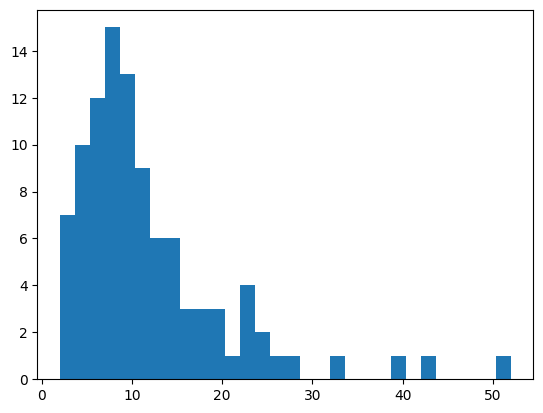

In [ ]:
# n_sample = 100
idset = [(id, data[id]['text_len'], data[id]['n_edges']) for id in data]
len_counts, len_indexs = count_len(idset)
id_set_100 = get_subset(100, len_counts, len_indexs, idset)

### utils

In [ ]:
def separate_parenthese(text):
    # add space around punctuation
    text = re.sub(r'([\(\)])', r' \1 ', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

g = separate_parenthese(graphs[i])
print(g)

( a / and :op2 ( t / tưởng :agent ( h / họ ) :tense ( s / sẽ ) :topic ( đ / điên :domain ( ô / ông ) ) ) )


In [ ]:
def reverse(text):
    # remove space around parentheses
    text = re.sub(r'([\(:])\s+', r'\1', text)
    text = re.sub(r'\s+(\))', r'\1', text)
    return text

g = reverse(g)
print(g)

(a / and :op2 (t / tưởng :agent (h / họ) :tense (s / sẽ) :topic (đ / điên :domain (ô / ông))))


In [18]:
def change_id(tokens, new_id):
    # change node ids to avoid duplicate ids (e.g. a -> a1, a2, ...)
    k = 1
    for i, token in enumerate(tokens):
        if token == '(':
            tokens[i + 1] = f'{new_id}{k}'
            k += 1
    return tokens

In [19]:
def check_parentheses(sentence):
    # check if parentheses are balanced
    stack = []
    for char in sentence:
        if char == '(':
            stack.append(char)
        elif char == ')':
            if not stack:
                return False
            stack.pop()
    return len(stack) == 0

def fix_parentheses(sentence):
    # fix unbalanced parentheses by removing unmatched ones
    stack = []
    unmatched_closing = []
    for i, char in enumerate(sentence):
        if char == '(':
            stack.append(i)
        elif char == ')':
            if stack:
                stack.pop()
            else:
                unmatched_closing.append(i)

    chars = list(sentence)
    for idx in reversed(stack + unmatched_closing):
        chars[idx] = ''

    fixed_sentence = ''.join(chars)
    return fixed_sentence

In [17]:
def smatch_score(prediction, target):
    # compute smatch score between two amr graphs (in penman format)
    # need to check logic (its giving score > 1.0)
    try:
        match_num, test_num, gold_num = smatch.get_amr_match(prediction, target)
    except:
        return -1
    else:
        precision, recall, f_score = smatch.compute_f(match_num, test_num, gold_num)
        return f_score

In [20]:
# test smatch
pred = '''(a / and
    :op1(n / ít_nhất
        :domain(t1 / ta)
        :mod(đ / đứng_đắn))
    :op2(c / chính_xác
        :degree(r / rất)
        :domain t1))'''
tar = '''(a / and
    :op1(n / người
        :domain(t1 / ta)
        :mod(đ / đứng_đắn))
    :op2(c / chính_xác
        :degree(r / rất)
        :domain t1))'''
print(pred)
print(tar)
smatch_score(tar, pred)

(a / and
    :op1(n / ít_nhất
        :domain(t1 / ta)
        :mod(đ / đứng_đắn))
    :op2(c / chính_xác
        :degree(r / rất)
        :domain t1))
(a / and
    :op1(n / người
        :domain(t1 / ta)
        :mod(đ / đứng_đắn))
    :op2(c / chính_xác
        :degree(r / rất)
        :domain t1))


0.9230769230769231

In [21]:
# get candidate nodes list for insert
def get_leaves(sent):
    # only leaves
    edges = set()
    leaves = set()
    items = change_id(sent.split())
    for i, item in enumerate(items):
        if item.startswith(':') and not re.match(':ARG\d+|:wiki|:op\d+|:snt\d+|:value|:polarity|:mode', item):
            if items[i + 1] not in ('(', ')'):
                edges.add(item)
                leaves.add(' '.join([item, items[i + 1]]))
            elif items[i + 1] == '(' and items[i + 5] == ')':
                edges.add(item)
                leaves.add(' '.join([item, items[i + 1], items[i + 2], items[i + 3], items[i + 4], items[i + 5]]))
    # print('different edge: %d' % len(edges))
    # print('different leaves: %d' % len(leaves))
    return list(leaves) #, list(edges)

def get_nodes(sent, role, new_id):
    # get leaves and internal nodes
    nodes = set()
    stack = []
    items = sent.split()
    # filtered_edge = [':ARG\d+', ':wiki', ':op\d+', ':value', ':polarity', ':mode', ':compound']
    # wanted_edge = [':time', ':initialTime', ':finalTime', ':duration', ':frequency', ':location', ':setting', ':initialLocation', ':finalLocation', ':mod', ':degree', ':manner']
    # pattern = '|'.join(filtered_edge)
    for i, item in enumerate(items):
        if item.startswith(':'): # and not re.match(pattern, item):
            stack.append((i, item))
            # if items[i + 1] != '(':
            #     stack.pop()
        elif item == ')':
            if len(stack) > 0:
                edge_id, edge = stack.pop()
                if edge == role and items[edge_id + 1] == '(':
                    candidate = items[edge_id:i+1]
                    candidate = change_id(candidate, new_id)
                    nodes.add(' '.join(candidate))
    return list(nodes)

In [22]:
def get_nodes_list(graphs, role, new_id):
    nodes_list = []
    for g in graphs:
        g = separate_parenthese(g)
        nodes_list += [fix_parentheses(reverse(node)) for node in get_nodes(g, role, new_id)]
    return list(set(nodes_list))

In [ ]:
def filter_role(role, new_id):
    # filter roles
    nodes_list = get_nodes_list(graphs, role, new_id)
    print(len(nodes_list))
    # print(nodes_list[:10])
    
    # validate
    for node in nodes_list:
        if not check_parentheses(node):
            print(node)
    
    # write to file
    base_dir = '../data/viamr/augmented/node-level/candidates/roles/'
    with open(f'{base_dir}candidates_{role[1:]}.txt', 'w', encoding='utf-8') as f:
        for node in nodes_list:
            f.write(node)
            f.write('\n')

# filter_role(':degree', 'deg')

## AMR modification

### insert

In [24]:
# find position of ')'
def index_item(tokens, token):
    res = []
    for i, t in enumerate(tokens):
        if t == token:
            res.append(i)
    return res

def insert_edge(graph, leaf_list, n=1, alpha=0.1):
    augs = []
    graph = separate_parenthese(graph)
    items = graph.split(' ')
    while n > 0:
        new_items = items.copy()
        edges = [i for i in new_items if i.startswith(':')]
        indexs = index_item(new_items, ')')
        n_ri = max(1, int(alpha * len(edges)))
        cand_existed = []
        while n_ri > 0:
            edges = [i for i in new_items if i.startswith(':')]
            new_leaf = random.choice(leaf_list)
            # print(new_leaf[:new_leaf.index('(')])
            if new_leaf[:new_leaf.index('(')].strip() in edges:
                cand_existed.append(new_leaf[:new_leaf.index('(')].strip())
                if len(set(cand_existed)) == 9:
                    break
                continue
            ind = random.choice(indexs) if new_leaf.startswith(':mod ') else indexs[-1]  # random if not :mod else add to root
            new_items[ind:ind] = new_leaf.split()
            n_ri -= 1
        aug = reverse(' '.join(new_items))
        try:
            dec_g = penman.decode(aug)
        except Exception as e:
            break
        try:
            enc_g = penman.encode(dec_g, indent=3)
        except:
            continue
        else:
            augs.append({'aug_graph': enc_g, 'inserted': new_leaf, 'score': smatch_score(enc_g, graph)})
        n -= 1
    return augs

### delete

In [ ]:
def delete_leaf(graph, n=1, alpha=0.1):
    try:
        g = penman.decode(graph)
    except Exception as e:
        print(graph)
        print(e)
        return []
    else:
        var = g.variables()
        leaves = {}
        filtered_out = [':arg\d+', ':agent', ':theme', ':pivot', ':patient', ':domain', ':name', ':compound'] # filter roles that should not be deleted
        for v in var:
            # remove node with re-entrancy
            if len(g.edges(source=v)) == 0 and len(g.edges(target=v)) == 1 and g.edges(target=v)[0][1] not in filtered_out:
                # get both instance and relation triple
                leaves[v] = [t for t in g.triples if (t[0] == v or t[2] == v)]
        # print(leaves)
        if len(leaves) == 0:
            return []
        
        augs = []
        n_edges = len(g.edges())
        while n > 0:
            # calculate number of nodes to delete
            n_rd = max(1, int(alpha * n_edges))
            # sample random nodes to delete
            candidates = random.sample(sorted(leaves), n_rd if n_rd <= len(leaves) else len(leaves))
            # print(candidates)
            removed_triples = []
            for cand in candidates:
                removed_triples += leaves.get(cand)
            edges = [t for t in g.triples if t not in removed_triples]
            new_graph = penman.Graph(edges, top=g.top)
            try:
                enc_g = penman.encode(new_graph, indent=3)
            except Exception as e:
                continue
            else:
                aug = {'aug_graph': enc_g, 'removed': removed_triples, 'score': smatch_score(enc_g, graph)}
                augs.append(aug)
            n -= 1
        return augs

In [ ]:
def delete_edge(graph, n=1, alpha=0.1):
    try:
        g = penman.decode(graph)
    except Exception as e:
        print(graph)
        print(e)
        return []
    else:
        var = g.variables()
        internals = {}
        for v in var:
            # get edge node with 1-level leaf, remove node with re-entrancy
            if v != g.top and len(g.edges(source=v)) == 1 and len(g.edges(target=v)) == 1:
                leaves = [leaf for leaf in var if len(g.edges(source=v, target=leaf)) > 0]
                internals[v] = [t for t in g.triples if t[0] == v or t[2] == v or t[0] in leaves]
        # print(internals)
        if len(internals) == 0:
            return []

        augs = []
        n_edges = len(g.edges())
        while n > 0:
            # copy_g = copy.deepcopy(g)
            n_rd = max(1, int(alpha * n_edges))
            candidates = random.sample(sorted(internals), n_rd if n_rd <= len(internals) else len(internals))
            # print(candidates)
            removed_triples = []
            for cand in candidates:
                removed_triples += internals.get(cand)
            edges = [t for t in g.triples if t not in removed_triples]
            new_graph = penman.Graph(edges, top=g.top)
            try:
                enc_g = penman.encode(new_graph, indent=3)
            except Exception as e:
                continue
            else:
                augs.append(enc_g)
            n -= 1
    return augs

In [44]:
print(graphs[100])
print(delete_leaf(graphs[100])[0]['aug_graph'])

(n / nói
    :agent(t1 / tôi)
    :modality(t2 / thèm)
    :goal(ô / ông
        :mod(t3 / ta))
    :polarity -
    :topic(o / or
        :op1(t4 / trăn
            :mod(r / rắn))
        :op2(r1 / rừng
            :mod(h / hoang))
        :op3(s / sao
            :classifier(v2 / vì))))
(n / nói
   :agent (t1 / tôi)
   :goal (ô / ông
      :mod (t3 / ta))
   :polarity -
   :topic (o / or
      :op1 (t4 / trăn
         :mod (r / rắn))
      :op2 (r1 / rừng
         :mod (h / hoang))
      :op3 (s / sao
         :classifier (v2 / vì))))


### substitute

In [27]:
# %pip install gensim

In [ ]:
def get_candidate_list(text, graph):
    # get candidate nodes from amr graph to replace by word type (POS)
    try:
        dec_g = penman.decode(graph)
    except:
        return []
    else:
        words = [w.target for w in dec_g.instances()]
        vars = [w.source for w in dec_g.instances()]
        tokens, pos = ViPosTagger.postagging(ViTokenizer.tokenize(text[7:]))
        node_pairs = {}
        for i, token in enumerate(tokens):
            if token not in words or pos[i] not in ('V', 'A', 'N') or len(token) == 1:
                continue
            id = vars[words.index(token)]
            # skip nodes in compound
            compound = dec_g.edges(role=':compound', target=id)
            if len(compound) > 0 and compound[0].source in node_pairs:
                del node_pairs[compound[0].source]
                continue
            node_pairs[id] = (token, pos[i])
        candidates = [item for item in node_pairs.values()]
    return candidates 

def get_synonyms(word, pos, model):
    # get list of synonyms from wordnet or w2v model to replace
    syns = []
    if model['type'] == 'wordnet':
        if word not in model['model'][pos]:
            return []
        syns = model['model'][pos][word]
    elif model['type'] == 'w2v':
        # get vectors
        try:
            similar_words = model['model'].most_similar(positive = [word], topn = 10)
        except KeyError:
            print(f"'{word}' not in vocabulary")
            return []
        else:
            for syn in similar_words:
                syn_pos = ViPosTagger.postagging(syn[0])[1][0] #(['a'], ['N'])
                if syn_pos == pos and syn[0].lower() != word:
                    syns.append(syn[0].lower())
    return syns

In [29]:
def substitute(text, graph, model, n=1, alpha=0.1):
    n_edges = len([i for i in separate_parenthese(graph) if i.startswith(':')])
    augs = []
    words = get_candidate_list(text, graph)
    if len(words) == 0:
        return []
    while n > 0:
        n_sr = max(1, int(alpha * n_edges))
        replaced = []
        no_syn = []
        new_graph = copy.deepcopy(graph)
        while n_sr > 0:
            if len(replaced) == len(words):
                break
            cand = random.choice([w for w in words if w not in replaced])
            synonyms = get_synonyms(*cand, model)
            if len(synonyms) == 0:
                no_syn.append(cand)
                if len(no_syn) == len(words):
                    break
                continue
            syn = random.choice(synonyms)
            new_graph = new_graph.replace(cand[0], syn)
            replaced.append(cand)
            n_sr -= 1
        augs.append({"aug_graph": new_graph, "replaced": replaced, "score": smatch_score(new_graph, graph)})
        n -= 1
    return augs

### change type

In [30]:
def invert(graph, pattern):
    inst = re.search(pattern, graph)
    if not inst:
        indexs = index_item(graph, ')')
        ind = random.choice(indexs)
        new_graph = graph[:ind] + pattern + graph[ind:]
    else:
        new_graph = new_graph.replace(pattern, '')
    try:
        dec_g = penman.decode(new_graph)
    except Exception as e:
        return
    try:
        enc_g = penman.encode(dec_g, indent=3)
    except:
        return
    else:
        return {'aug_graph': enc_g, 'score': smatch_score(new_graph, graph)}

### shuffle

In [31]:
def shuffle(graph):
    try:
        dec_g = penman.decode(graph)
    except:
        return
    try:
        random.shuffle(dec_g.triples)
        enc_g = penman.encode(dec_g)
    except:
        return
    else:
        return {'aug_graph': enc_g, 'score': smatch_score(enc_g, graph)}

### contraposition

In [30]:
def has_polarity_negative(g, z1):
    for triple in g.triples:
        if triple == (z1, ':polarity', '-'):
            return triple

In [31]:
def swappable_contra(g):
    for inst in g.instances():
        if (len(g.edges(source=inst.source, role=':condition')) == 1) and inst.target != 'and':
            return inst.source

def contraposition(graph):
    '''A -> B = not(B) -> not(A)'''
    try:
        g = penman.decode(graph)
    except:
        return
    else: 
        z0 = swappable_contra(g)
        if z0 is None:
            return
        z1 = g.edges(source=z0, role=':condition')[0].target
        z1_neg = has_polarity_negative(g, z1)
        z0_neg = has_polarity_negative(g, z0)

        # add negative polarity to both clauses
        if z1_neg is None and z0_neg is None:
            g.triples.append((z1, ':polarity', '-'))
            g.triples.append((z0, ':polarity', '-'))
        elif z1_neg is not None and z0_neg is not None:
            g.triples.remove(z1_neg)
            g.triples.remove(z0_neg)
        elif z1_neg is None and z0_neg is not None:
            g.triples.remove(z0_neg)
            g.triples.append((z1, ':polarity', '-'))
        elif z1_neg is not None and z0_neg is None:
            g.triples.remove(z1_neg)
            g.triples.append((z0, ':polarity', '-'))

        # modify root node
        root = g.edges(target=z0)
        if len(root) > 0:
            g.triples.remove((root[0].source, root[0].role, z0))
            g.triples.append((root[0].source, root[0].role, z1))

        # change condition
        g.triples.remove((z0, ':condition', z1))
        g.triples.append((z1, ':condition', z0))

        try:
            new_graph = penman.encode(g, indent=3)
        except Exception as e:
            # print(graph)
            # print(g)
            # print(e)
            return
        else:
            return {'aug_graph': new_graph, 'score': smatch_score(new_graph, graph)}

### implication

In [32]:
def swappable_impli(g):
    for inst in g.instances():
        if (inst.target == 'or'   ## this elif is working for implication law
         and len(g.edges(source=inst.source, role=':op1')) == 1
         and len(g.edges(source=inst.source, role=':op2')) == 1
         and len(g.edges(target=inst.source)) == 0):
            yield inst.source

def implication_negative(g, z1):
    z1_neg = has_polarity_negative(g, z1)
    if z1_neg is None:
        g.triples.append((z1, ':polarity', '-'))
    else:
        g.triples.remove(z1_neg)
    return g

In [33]:
def implication(graph):
    '''A -> B = not(A) or B'''
    try:
        g = penman.decode(graph)
    except:
        return []
    else:
        augs = []
        z0 = swappable_contra(g)
        if z0 is not None:
            root = g.edges(target=z0)
            if len(root) == 0:
                z1 = g.edges(source=z0, role=':condition')[0].target
                # add negative polarity
                g = implication_negative(g, z1)
                # 'condition' -> 'or'
                os = len([wz for wz in g.variables() if wz.startswith('o')])
                source = 'o' if os == 0 else f'o{os}'
                g.triples.remove((z0, ':condition', z1))
                g.triples.append((source, ':instance', 'or'))
                g.triples.append((source, ':op1', z1))
                g.triples.append((source, ':op2', z0))

                try:
                    new_graph = penman.encode(g, indent=3, top=source)
                except Exception as e:
                    # print(graph)
                    # print(g)
                    # print(e)
                    return []
                else:
                    augs += [{'aug_graph': new_graph, 'score': smatch_score(new_graph, graph)}]
        else:
            for z in swappable_impli(g):
                root = g.edges(target=z)
                if len(root) == 0:
                    g_temp = copy.deepcopy(g)
                    ## A or B
                    z1 = g.edges(source=z, role=':op1')[0].target
                    z5 = g.edges(source=z, role=':op2')[0].target
                    
                    # add negative polarity
                    g = implication_negative(g, z1)
                    
                    # 'or' -> 'condition'
                    g.triples.remove((z, ':instance', 'or'))
                    g.triples.remove((z, ':op1', z1))
                    g.triples.remove((z, ':op2', z5))
                    g.triples.append((z5, ':condition', z1))
                    
                    g.metadata = {}
                    g.epidata = {}
                    try:
                        new_graph = penman.encode(g, indent=3, top=z5)
                    except:
                        return augs
                    else:
                        augs.append({'aug_graph': new_graph, 'score': smatch_score(new_graph, graph)})
                    
                    ## B or A
                    # add negative polarity
                    g_temp = implication_negative(g_temp, z5)

                    # 'or' -> 'condition'
                    g_temp.triples.remove((z, ':instance', 'or'))
                    g_temp.triples.remove((z, ':op1', z1))
                    g_temp.triples.remove((z, ':op2', z5))
                    g_temp.triples.append((z1, ':condition', z5))
                    
                    g_temp.metadata = {}
                    g_temp.epidata = {}
                    try:
                        new_graph_temp = penman.encode(g_temp, indent=3, top=z1)
                    except:
                        return augs
                    else:
                        augs.append({'aug_graph': new_graph_temp, 'score': smatch_score(new_graph, graph)})
        return augs

### commutative

In [34]:
def swappable_commu(g):
    for inst in g.instances():
        if (inst.target == 'and'   # find sentence with 'and'
         and len(g.edges(source=inst.source, role=':op1')) == 1 # make sure it has at least 2 clauses
         and len(g.edges(source=inst.source, role=':op2')) == 1
         and len(g.edges(target=inst.source)) == 0):
            yield inst.source

def swappable_commu_2(g):
    for inst in g.instances():
        if (inst.target == 'contrast-01'   # find sentence with 'and'
         and len(g.edges(source=inst.source, role=':ARG1')) == 1 # make sure it has at least 2 clauses
         and len(g.edges(source=inst.source, role=':ARG2')) == 1
         and len(g.edges(target=inst.source)) == 0):
            yield inst.source

def switch_node(g, source, relations):
    z1 = g.edges(source=source, role=relations[0])[0].target
    z5 = g.edges(source=source, role=relations[1])[0].target
    g.triples.remove((source, relations[0], z1))  # remove the triples
    g.triples.remove((source, relations[1], z5))
    g.triples.append((source, relations[0], z5))  # add the replacements
    g.triples.append((source, relations[1], z1))
    return g

def commutative(graph):
    try:
        g = penman.decode(graph)
    except:
        return
    else:
        sources = list(swappable_commu(g)) + list(swappable_impli(g)) + list(swappable_commu_2(g))
        if len(sources) == 0:
            return
        for z0 in sources:
            if z0.startswith('c'):
                relations = [':ARG1', ':ARG2']
            else:
                relations = [':op1', ':op2']
            g = switch_node(g, z0, relations)
        new_graph = penman.encode(g, indent=3)
        return {'aug_graph': new_graph, 'score': smatch_score(new_graph, graph)}

### combi

In [ ]:
def random_augment(text, graph, insert_list, sub_model, max_iter=3, lthres = 0.7, hthres=0.8):
    augs = {'ori': graph, 'log': []}
    normal = [insert_edge, delete_leaf, substitute, shuffle, invert]
    aug = copy.deepcopy(graph)
    mut = 1
    while mut <= max_iter:
        case = random.choice(normal)
        if case == insert_edge:
            tmp = case(aug, insert_list)
        elif case == substitute:
            tmp = case(text, aug, sub_model)
        else:
            tmp = case(aug)
        if len(tmp) == 0:
            continue
        aug = tmp[0]
        augs['log'].append({'case':case.__name__, 'aug':aug, 'score':smatch_score(aug, graph)})
        mut += 1
        score = smatch_score(aug, graph)
        if score == -1:
            continue
        if lthres <= score <= hthres:
            break
    return augs

In [ ]:
# test 1 graph
i = random.randint(0, len(graphs))
augs_combi = random_augment(texts[i], graphs[i], insert_list=insert_nodes, sub_model=model_w2v, max_iter=3)

print(augs_combi['ori'])
for log in augs_combi['log']:
    print(log['case'])
    print(log['aug'])
    print(log['score'])

In [131]:
# whole dataset
data_augs = []
for i in tqdm(range(len(graphs)), total=len(graphs)):
    try:
        augs_combi = random_augment(texts[i], graphs[i], insert_list=insert_nodes, sub_model=model_w2v, max_iter=3)
    except:
        # print(e)
        continue
    else:
        data_augs.append(augs_combi)

100%|██████████| 1516/1516 [00:00<00:00, 11538.03it/s]


In [ ]:
print(len(data_augs))
print(data_augs[0])

In [ ]:
output = 'data/viamr/augmented/node-level/aug_maxiter-3.json'
with open(output, 'x', encoding='utf-8') as f:
     json.dump(data_augs, f, indent=4, sort_keys=True, ensure_ascii=False)

### example

In [27]:
def random_insert(data, leaf_list):
    augs_insert = {}
    for i in tqdm(data, total=len(data)):
        aug = insert_edge(data[i]['ori_graph'], leaf_list)
        if len(aug) > 0:
            data[i]['aug_insert'] = aug[0]
            augs_insert[i] = data[i]
    return augs_insert

# delete only
def random_delete(data):
    for i in tqdm(data, total=len(data)):
        # print(data[i])
        aug = delete_leaf(data[i]['ori_graph'])
        if len(aug) > 0:
            data[i]['aug_delete'] = aug[0]
    return data

def syn_replace(data, model):
    for i in tqdm(data, total=len(data)):
        aug = substitute(data[i]['ori_text'], data[i]['ori_graph'], model)
        if len(aug) > 0:
            data[i][f'aug_syn_{model["type"]}'] = aug[0]
    return data

def combi(data, leaf_list, model):
    for i in tqdm(data, total=len(data)):
        aug = random_augment(data[i]['ori_text'], data[i]['ori_graph'], leaf_list, model, max_iter=5)
        if len(aug['log']) > 0:
            data[i]['aug_combi'] = aug['log'][-1]['aug']
    return data

def contra(data):
    augs_contra = {}
    for i in tqdm(data, total=len(data)):
        aug = contraposition(data[i]['ori_graph'])
        if aug is not None:
            data[i]['aug_contra'] = aug
            augs_contra[i] = data[i]
    return augs_contra

def impli(data):
    augs_impli = {}
    for i in tqdm(data, total=len(data)):
        aug = implication(data[i]['ori_graph'])
        if len(aug) > 0:
            data[i]['aug_impli'] = aug[0]
            augs_impli[i] = data[i]
    # return data
    return augs_impli

def commu(data):
    augs_commu = {}
    for i in tqdm(data, total=len(data)):
        aug = commutative(data[i]['ori_graph'])
        if aug is not None:
            data[i]['aug_commu'] = aug
            augs_commu[i] = data[i]
    return augs_commu

In [56]:
augs_delete = random_delete(data)
augs_insert = random_insert(data, insert_nodes)
augs_syn_w2v = syn_replace(data, model=model_w2v)
augs_syn_wn = syn_replace(data, model=model_wordnet)
# augs_commu = commu(data)
# augs_impli = impli(data)
# augs_contra = contra(data)

 54%|█████▍    | 816/1516 [00:14<00:02, 344.42it/s]ignoring epigraph data for duplicate triple: ('l', ':domain', 'n')
ignoring epigraph data for duplicate triple: ('c', ':agent', 'ô')
 35%|███▌      | 533/1516 [00:05<00:11, 88.97it/s] ignoring secondary node contexts for 'ô'
Error in parsing AMR (đ / đáp
   :agent (ô / ông
      /
 54%|█████▍    | 826/1516 [00:06<00:02, 337.07it/s]ignoring epigraph data for duplicate triple: ('l', ':domain', 'n')
ignoring secondary node contexts for 'l'
 57%|█████▋    | 864/1516 [00:06<00:02, 313.35it/s]ignoring epigraph data for duplicate triple: ('c', ':agent', 'ô')
ignoring secondary node contexts for 'c'
 68%|██████▊   | 1033/1516 [00:07<00:01, 246.84it/s]ignoring epigraph data for duplicate triple: ('c', ':pivot', 'g')
ignoring secondary node contexts for 'c'
  0%|          | 3/1516 [00:03<23:30,  1.07it/s]  

'b612' not in vocabulary


100%|██████████| 1516/1516 [00:10<00:00, 150.86it/s]


In [456]:
# output = 'data/viamr/augmented/data.json'
# with open(output, 'w', encoding='utf-8') as f:
#     json.dump(data, f, indent=4, sort_keys=True, ensure_ascii=False)

In [ ]:
augs_delete

In [57]:
none_del_1, none_insert_1, none_syn_w2v_1, none_syn_wn_1 = [], [], [], []
for i in augs_delete:
    if len(augs_delete[i]['aug_delete']['removed']) == 0:
        none_del_1.append(i)
    if 'aug_syn_w2v' not in augs_delete[i] or len(augs_delete[i]['aug_syn_w2v']['replaced']) == 0:
        none_syn_w2v_1.append(i)
    if 'aug_syn_wordnet' not in augs_delete[i] or len(augs_delete[i]['aug_syn_wordnet']['replaced']) == 0:
        none_syn_wn_1.append(i)
    if 'aug_insert' not in augs_delete[i] or augs_delete[i]['aug_insert']['inserted'] is None:
        none_insert_1.append(i)

In [ ]:
print(len(none_del_1))
print(len(none_insert_1))
print(len(none_syn_w2v_1))
print(len(none_syn_wn_1))

## generate

In [ ]:
# %pip install -q -U google-genai

^C
Note: you may need to restart the kernel to use updated packages.


In [138]:
from google import genai
import dotenv

api_key = dotenv.get_key('.env', 'GEMINI_API_KEY')
client = genai.Client(api_key=api_key)

In [139]:
def one_shot(graph):
    return f'''
    ## Instruction 
    You are a Vietnamese expert linguist. You will be provided an abstract meaning representation (AMR). Your task is to generate a clear and grammatically correct sentence in Vietnamese based on the given AMR. 
    
    ## Context 
    Follow some additional rules and notes when generating sentences:
    - ":classifier" is used for noun classifier, which standing before a noun. 
    - ":compound" is used for compound word, such as "(ă / ăn :compound (u / uống))" = "ăn uống". 
    - ":mode" indicates type of sentence: "imperative" for commands or instructions or suggestions, "interrogative" for yes-no questions, "expressive" for sentence with exclamational words that express emotions. 
    - "amr-unknown" for WH-question, where the relation which contains "amr-unknown" is the target of the question. For example, "(l / làm :manner (amr-unknown))" = "làm như thế nào"
    - ":polarity -" is for negatives. 
    - "a / and", "o / or", "m / multi-sentence", "c / contrast-01" indicate multiple clauses within a sentence or multiple sentences, in which ":op1"/":snt1"/":ARG1" is the first clause/sentence, ":op2"/":snt2"/":ARG2" is the second,... respectively.
    - nodes with the same id refer to the same entity.
    - ":condition" indicates conditional sentence. "X :condition Y" = "nếu Y thì X", and "X :condition-of Y" = "nếu X thì Y"
    
    ## Requirements
    - The sentence must make sense, be grammatically correct, and accurately reflect the content of the AMR.
    - The words must be logically arranged, closely reflecting the relationships in the AMR structure.
    - The sentence should sound natural and understandable.
    - You can rearrange parts in the sentence structure, or add some few words when needed, but make sure to keep the same meaning.
    - No extra comments or explanation needed.

    ## Example
    Graph: 
    (c / contrast-01
        :ARG2(p / phí
            :theme(t / thì_giờ
                :quant(n1 / nhiều)
                :poss(b / bạn))
            :goal(h / hình_phạt
                :mod(đ1 / đó))
            :agent b
            :polarity -
            :mode imperative))
    Sent: Nhưng đừng có phí nhiều thì giờ của bạn vào hình phạt đó.

    ## Input
    Graph: {graph}
    Sent: 
    '''

def get_answer(graph):
    # model = 'gemini-2.5-flash-preview-04-17'
    model = 'gemini-2.0-flash' 
    response = client.models.generate_content(model=model,
                                              contents=[one_shot(graph)])
    return response.text.strip()

In [333]:
graph = '''(c / có
   :polarity -
   :theme (c1 / chỗ
       :mod (md1 / xuất_hiện)
       :beneficiary (n / người
         :quant 2)))
'''

get_answer(graph)

'Không có chỗ nào xuất hiện hai người.'

In [152]:
graph

'(c1 / cháy\n   :theme (n1 / núi_lửa\n      :classifier (q / quả))\n   :tense (s / sẽ)\n   :result (w1 / and\n      :op2 (đ / đỏ\n         :polarity -)\n      :op1 (đ1 / đều\n         :polarity -)\n      :op3 (p / phun\n         :compound (t / trào)))\n   :condition-of (n / nạo_vét\n      :manner (k / kỹ)\n      :polarity -))'

In [83]:
def gen_sent(data, id_subset, method): #id_subset
    for i in tqdm(id_subset, total=len(id_subset)):
        if len(data[i][method]) == 0:
            continue
        gen_sent = get_answer(data[i][method]['aug_graph'])
        data[i][method]['aug_text'] = gen_sent
        time.sleep(4)
    return data

def get_placeholders(data, method):
    for i in data:
        if method in data[i]:
            data[i][method]['eval_text'] = []
            data[i][method]['eval_graph'] = []
            data[i][method]['error_type_text'] = []
            data[i][method]['error_type_graph'] = []
        else:
            data[i][method] = {}
    return data

In [100]:
with open('data/viamr/augmented/aug_delete.json', encoding='utf-8') as f:
    id_set_200 = json.load(f)

In [ ]:
keyset = list(map(int, id_set_200.keys()))
sorted(keyset)

In [ ]:
subset = {i:data[i] for i in sorted(keyset)}
subset

In [ ]:
for i in subset:
    subset[i]['aug_graph'] = shuffle(subset[i]['ori_graph'])

In [ ]:
subset

In [119]:
for i in tqdm(keyset, total=len(keyset)):
    gen_sent = get_answer(subset[i]['aug_graph']['aug_graph'])
    subset[i]['aug_text'] = gen_sent
    time.sleep(5)

100%|██████████| 200/200 [21:40<00:00,  6.50s/it]


In [120]:
output = 'data/viamr/augmented/aug_swap.json'
with open(output, 'w', encoding='utf-8') as f:
    # augs_insert = get_placeholders(augs_insert, "aug_insert")
    json.dump(subset, f, indent=4, sort_keys=True, ensure_ascii=False)

### statistics

In [ ]:
leaves = []
for g in graphs:
    g = separate_parenthese(g)
    leaves += [reverse(l) for l in get_leaves(g)]

In [ ]:
roles = {}
for g in graphs:
    try:
        dec_g = penman.decode(g)
    except:
        continue
    else:
        for t in dec_g.edges():
            edge = t.role
            if edge in roles:
                roles[edge][0] += 1
            else:
                roles[edge] = [1]

for leaf in leaves:
    if '(' in leaf:
        role = leaf[:leaf.index('(')].strip()
        if role not in roles:
            roles[role] = [0, 1]
        elif length(roles[role]) == 1:
            roles[role].append(1)
        else:
            roles[role][1] += 1

In [ ]:
roles = dict(sorted(roles.items(), key=lambda x: x[1][0], reverse=True))
roles

In [ ]:
role = ':mod'
parents = {}
for g in graphs:
    try:
        dec_g = penman.decode(g)
    except:
        continue
    else:
        filter_triple = [t for t in dec_g.edges(role=role)]
        if length(filter_triple) == 0:
            continue
        for t in filter_triple:
            src = t.source
            par_node = dec_g.edges(target=src)
            if length(par_node) > 0:
                # src_text = [tri.target for tri in dec_g.instances() if tri.source == src]
                src_role = par_node[0].role
                if src_role in parents:
                    parents[src_role] += 1
                else:
                    parents[src_role] = 1
            else:
                if 'root' not in parents:
                    parents['root'] = 1
                else:
                    parents['root'] += 1

In [ ]:
parents = dict(sorted(parents.items(), key=lambda x: x[1], reverse=True))
parents

## evaluation

In [33]:
with open('data/viamr/augmented/ver100/p1/aug_impli.json', encoding='utf-8') as f:
    eval_1 = json.load(f)
with open('data/viamr/augmented/ver100/p2/aug_delete.json', encoding='utf-8') as f:
    eval_2 = json.load(f)
with open('data/viamr/augmented/ver100/p3/aug_delete.json', encoding='utf-8') as f:
    eval_3 = json.load(f)
eval = [eval_1, eval_2, eval_3]

In [22]:
def get_amr(eval, method):
    eval_errors, eval_corrects = [], []
    for ev in eval:
        errors, corrects = {}, {}
        for i in ev:
            if 'error_type_graph' in ev[i][method]:
                if len(ev[i][method]['error_type_graph']) != 0:
                    errors[i] = ev[i]
            if 'eval_text' in ev[i][method]:
                if len(ev[i][method]['eval_text']) != 0:
                    corrects[i] = ev[i]
        eval_errors.append(errors)
        eval_corrects.append(corrects)
    return eval_errors, eval_corrects

def get_scores(eval, method):
    eval_total = []
    for ev in eval:
        eval_text = []
        for i in ev:
            # if len(eval[i][method]['eval_graph']) == 0:
            #     continue
            eval_text.append(ev[i][method]['eval_text'])
        eval_total.append(eval_text)
    return eval_total

def get_score_and_len(eval, method):
    pairs = []
    for i in eval:
        if len(eval[i][method]['eval_text']) != 0:
            pairs.append((*eval[i][method]['eval_text'], eval[i]['text_len'], eval[i]['n_edges']))
    return pairs

def get_above_avg(eval, method, score=(3, 3)):
    pairs = []
    for i in eval:
        if 'eval_text' in eval[i][method] and len(eval[i][method]['eval_text']) != 0:
            fluency = eval[i][method]['eval_text'][0]
            semantic = eval[i][method]['eval_text'][1]
            if fluency >= score[0] and semantic >= score[1]:
                pairs.append((i, fluency, semantic))
    return pairs

def compute(lst):
    total_scores = []
    for l in lst:
        scores = []
        for j in range(len(l[0])):
            score_lst = [l[i][j] for i in range(len(l))]
            scores.append(sum(score_lst) / len(score_lst))
        total_scores.append(scores)
    return np.mean([item[0] for item in total_scores]), np.mean([item[1] for item in total_scores])

def get_amr_errors(eval, method):
    error_type_graph = {'incorrect': [], "time": [], "ori": [], 'wrong_edge': [],
                        'not_suitable': [], 'none': [], 'accepted':[], 'wrong_place':[], 'irrelevant':[], 'compound':[], 'tense':[]}
    for i in eval:
        if 'error_type_graph' in eval[i][method]:
            for item in eval[i][method]['error_type_graph']:
                error_type_graph[item].append(eval[i][method]['eval_graph'])
    return error_type_graph

def get_sent_errors(eval, method):
    error_type_text = {'missing_info': 0, 'extra_info': 0, 'semantic': 0, 'wrong_type': 0, 'grammar': 0, "creative": 0, "ori": 0}
    for i in eval:
        if 'error_type_text' in eval[i][method]:
            for item in eval[i][method]['error_type_text']:
                error_type_text[item] += 1
    return error_type_text

In [32]:
method = "aug_impli"
errors, corrects = get_amr(eval, method)
print(len(corrects[0]))
print(len(errors[0]))

eval_text = get_scores(corrects, method)
text_score = compute(eval_text)
print(text_score)

error_type_graph = get_amr_errors(errors[0], method)
error_type_text = get_sent_errors(corrects[1], method)
print(error_type_graph)
print(error_type_text)
# print(sr_by_length)

sum(text_score) / 2

KeyError: 'aug_impli'

In [141]:
for i in error_type_graph:
    print(i, end=': ')
    print(len(error_type_graph[i]) / len(eval[0]) * 100)

print('\n')
for i in error_type_text:
    print(i, end=': ')
    print(error_type_text[i] / len(corrects[0]) * 100)

incorrect: 6.0606060606060606
time: 0.0
ori: 0.0
wrong_edge: 0.0
not_suitable: 36.36363636363637
none: 0.0
accepted: 0.0
wrong_place: 0.0
irrelevant: 0.0
compound: 0.0
tense: 0.0


missing_info: 52.38095238095239
extra_info: 23.809523809523807
semantic: 47.61904761904761
wrong_type: 38.095238095238095
grammar: 0.0
creative: 0.0
ori: 0.0


In [34]:
pairs = get_above_avg(eval_1, method)
len(pairs)
# pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
# pairs

6

In [ ]:
contra_scores = [pairs[i][0] for i in range(len(pairs))]
contra_lens = [pairs[i][1] for i in range(len(pairs))]
print(np.mean(contra_lens))
print(np.mean(contra_scores))

16.5
3.9151785714285716


### filter 100

In [281]:
aug_method = 'aug_insert'

with open(f'data/viamr/augmented/ver200/eval/quang/{aug_method}.json', encoding='utf-8') as f:
    ori_data = json.load(f)

subset = {i:ori_data[i] for i in id_set_100_i}

with open(f'data/viamr/augmented/ver100/{aug_method}.json', 'w', encoding='utf-8') as f:
    json.dump(subset, f, indent=4, sort_keys=True, ensure_ascii=False)

In [204]:
with open(f'data/viamr/augmented/ver100/{aug_method}.json', 'r', encoding='utf-8') as f:
    augs_method = json.load(f)

with open(f'data/viamr/augmented/ver100/{aug_method}.txt', 'w', encoding='utf-8') as f:
    for i in augs_method:
        f.write(i + '\n')
        f.write(augs_method[i]['ori_text'] +'\n')
        f.write(augs_method[i]['ori_graph'] +'\n')
        f.write(f'{aug_method}:' + '\n')
        f.write('syn_w2v:' + '\n')
        if 'aug_graph' in augs_method[i]['aug_syn_w2v']:
            f.write(augs_method[i]['aug_syn_w2v']['aug_graph'] +'\n')
            f.write(augs_method[i]['aug_syn_w2v']['aug_text'] + '\n')
        f.write('syn_wordnet:' + '\n')
        if 'aug_graph' in augs_method[i]['aug_syn_wordnet']:
            f.write(augs_method[i]['aug_syn_wordnet']['aug_graph'] + '\n')
            f.write(augs_method[i]['aug_syn_wordnet']['aug_text'] + '\n')

## test

In [156]:
i = random.randint(0, len(graphs))
test_data = data[i]

In [164]:
def test(data):
    aug_insert = insert_edge(data['ori_graph'], insert_nodes)
    data['aug_insert'] = aug_insert

    aug_delete = delete_leaf(data['ori_graph'])
    data['aug_delete'] = aug_delete

    aug_syn_w2v = substitute(data['ori_text'], data['ori_graph'], model_w2v)
    data['aug_syn_w2v'] = aug_syn_w2v

    aug_syn_wn = substitute(data['ori_text'], data['ori_graph'], model_w2v)
    data['aug_syn_wn'] = aug_syn_wn

    return data

def test_contra(data):
    aug = contraposition(data['ori_graph'])
    if aug is not None:
        data['aug_contra'] = aug
    return data

def test_commu(data):
    aug = commutative(data['ori_graph'])
    if aug is not None:
        data['aug_commu'] = aug
    return data

def test_impli(data):
    aug = implication(data['ori_graph'])
    if aug is not None:
        data['aug_impli'] = aug
    return data

In [161]:
test_data1 = '''(ă / ăn
    :agent (e / em)
    :theme (c / cơm)
    :mode interrogative)'''

text_js = {'ori_text': '#::snt em ăn cơm chưa ?', 'ori_graph': test_data1}

In [154]:
def write_output_1(data, file):
    with open(file, 'w', encoding='utf-8') as f:
        f.write(f'original text: {data["ori_text"]}\n')
        f.write(f'original graph:\n {data["ori_graph"]}\n')
        f.write(f'aug_insert:\n {data["aug_insert"][0]["aug_graph"]}\n')
        f.write(f'aug_delete:\n {data["aug_delete"][0]["aug_graph"]}\n')
        f.write(f'aug_syn_w2v:\n {data["aug_syn_w2v"][0]["aug_graph"]}\n')
        f.write(f'aug_syn_wn:\n {data["aug_syn_wn"][0]["aug_graph"]}\n')

def write_output_2(data, file, method):
    with open(file, 'w', encoding='utf-8') as f:
        f.write(f'original text: {data["ori_text"]}\n')
        f.write(f'original graph:\n {data["ori_graph"]}\n')
        f.write(f'{method}:\n {data[method][0]["aug_graph"]}\n')

In [165]:
text_js = test(text_js)
write_output_1(text_js, 'data/viamr/test_output.txt')
text_js

{'ori_text': '#::snt em ăn cơm chưa ?',
 'ori_graph': '(ă / ăn\n    :agent (e / em)\n    :theme (c / cơm)\n    :mode interrogative)',
 'aug_insert': [{'aug_graph': '(ă / ăn\n   :agent (e / em)\n   :theme (c / cơm)\n   :mode interrogative\n   :time (ti8 / before\n      :op1 (ti9 / now\n         :quant (ti10 / temporal-quantity\n            :quant 1\n            :unit (ti11 / tuần)))))',
   'inserted': ':time (ti8 / before :op1 (ti9 / now :quant (ti10 / temporal-quantity :quant 1 :unit (ti11 / tuần))))',
   'score': 0.5217391304347825}],
 'aug_delete': [{'aug_graph': '(ă / ăn\n   :agent (e / em)\n   :mode interrogative)',
   'removed': [('ă', ':theme', 'c'), ('c', ':instance', 'cơm')],
   'score': 0.8333333333333333}],
 'aug_syn_w2v': [{'aug_graph': '(ă / ăn\n    :agent (e / bé)\n    :thbée (c / cơm)\n    :mode interrogative)',
   'replaced': [('em', 'N')],
   'score': 0.7142857142857143}],
 'aug_syn_wn': [{'aug_graph': '(ă / ăn\n    :agent (e / cậu)\n    :thcậue (c / cơm)\n    :mode int

In [ ]:
test1 = data[22] # contra, impli
test2 = data[78] # commu

In [155]:
test1 = test_contra(test1)
test2 = test_commu(test2)
test3 = test_impli(test1)

write_output_2(test1, 'data/viamr/test_output_1.txt', 'aug_contra')
write_output_2(test2, 'data/viamr/test_output_2.txt', 'aug_commu')
write_output_2(test1, 'data/viamr/test_output_3.txt', 'aug_impli')

KeyError: 0